# 介绍

### 项目介绍
- 这里使用TensorFlow搭建CNN识别mnist手写数字特征
- 这份代码参照LeNet-5架构，论文阅读及下载地址：http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf）
- 架构的详细描述请看下面搭建CNN的描述

# 步骤 

## 1. 导入工具库和准备数据

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

# os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
# warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

- 这里的all_mnist_data.csv是重新包装后的所有原始mnist数据，共70000个手写数字，数据详情及下载请阅读我GitHub主页上的介绍[GitHub：acphart/Deep_in_mnist](https://github.com/acphart/Deep_in_mnist)

In [2]:
data = pd.read_csv('../../dataset/all_mnist_data.csv').values

In [3]:
'''
切分数据，训练集为59000， 交叉验证集为1000， 测试集为10000；
交叉验证集过大会导致内存溢出（gpu内存不足），同时也不必要设置太大，
1000足够了，太大了还会拖慢训练速度；
'''
tr_r = 59000
cv_r = 60000

train = data[:tr_r]
cv = data[tr_r:cv_r]
test = data[cv_r:]

## 2. 定义搭建CNN的相关函数

In [4]:
'''
向量化函数，将相应数字转换成one-hot向量，如下：
0 => [1 0 0 0 0 0 0 0 0 0]
1 => [0 1 0 0 0 0 0 0 0 0]
...
9 => [0 0 0 0 0 0 0 0 0 1]
'''
def vectorize(y_flat):
    n = y_flat.shape[0]
    vectors = np.zeros((n, 10))
    for i in range(n):
        vectors[i][int(y_flat[i])] = 1.0
    return vectors.astype(np.uint8)

In [5]:
'''权重初始化函数'''
def init_weights(shape, name=None):
    weights = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(weights, name=name)

'''偏置初始化函数'''
def init_biases(shape, name=None):
    biases = tf.constant(0.1, shape=shape)
    return tf.Variable(biases, name=name)

'''卷积函数，步长为1，返回与输入图像shape相同的特征映射(padding='SAME')'''
def conv2d(putin, conv_k, name=None):
    return tf.nn.conv2d(putin, conv_k, 
                        strides=[1, 1, 1, 1], padding='SAME', name=name)

'''池化函数，2*2最大池化，步长为2，池化后图像长宽各减半'''
def max_pool22(putin, name=None):
    return tf.nn.max_pool(putin, ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding='SAME', name=name)

## 3. 搭建CNN

### 3.1 CNN结构
- 我们这里参考LeNet-5网络结构，相关论文地址：http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf）

- 输入层通过reshape原始的特征向量转换为一批28x28单通道（灰度）的手写数字图片putin
- putin随后通过第一卷积层得到32个特征映射，然后经第一层池化图片大小缩减为14x14
- 经过第二卷积层得到64个特征映射，然后经第二层池化图片大小缩减为7x7
- 然后进入全连接层，进入之前需要reshape第二池化层出来的Tensor
- 在全连接层设置弃权，可以加速训练和防止过拟合
- 到达输出层

- 这里我用中文注释说明CNN的结构，英文注释代表了Tensor维度的变化，这里很容易体会到TensorFlow名字的意思=> 张量流

### 3.2 输入层

In [6]:
'''x为原始输入数据，即特征向量，None代表可以批量喂入数据'''
'''y为对应输入数据的期望输出结果，即真实值'''
x = tf.placeholder(np.float32, [None, 784], name='x')
y = tf.placeholder(np.float32, [None, 10], name='y')
'''x is the original Tensor => [m, 784]'''


'''输入层，-1代表让函数自动计算第一维的大小'''
'''这里将原始输入转换成一批单通道图片'''
putin = tf.reshape(x, [-1, 28, 28, 1], name='putin')
'''after reshape, Tensor => [m, 28, 28, 1]'''

'after reshape, Tensor => [m, 28, 28, 1]'

### 3.3 第一卷积层和池化层

In [8]:
'''第一卷积层的卷积核：5x5局部感受野，单通道，32个特征映射'''
'''使用修正线性单元ReLU作为激活函数'''
w_conv1 = init_weights([5, 5, 1, 32], name='w_conv1')
b_conv1 = init_biases([32], name='b_conv1')
h_conv1 = tf.nn.relu(conv2d(putin, w_conv1) + b_conv1, name='h_conv1')
'''after conv2d by w_conv1, padding_type is "SAME", Tensor => [m, 28, 28, 32]'''


'''第一池化层，2*2最大值池化'''
pool_1 = max_pool22(h_conv1, name='pool_1')
'''after pooling by [1, 2, 2, 1], padding_type is "SAME", Tensor => [m, 14, 14, 32]'''

'after pooling by [1, 2, 2, 1], padding_type is "SAME", Tensor => [m, 14, 14, 32]'

### 3.4 第二卷积层和池化层

In [9]:
'''第二卷积层的卷积核：5x5局部感受野，32通道，64个特征映射'''
'''依旧使用ReLU作为激活函数'''
w_conv2 = init_weights([5, 5, 32, 64], name='w_conv2')
b_conv2 = init_biases([64], name='b_conv2')
h_conv2 = tf.nn.relu(conv2d(pool_1, w_conv2) + b_conv2, name='h_conv2')
'''after conv2d by w_conv2, padding_type is "SAME", Tensor => [m, 14, 14, 64]'''


'''第二池化层，2*2最大值池化'''
pool_2 = max_pool22(h_conv2, name='pool_2')
'''after pooling by [1, 2, 2, 1], padding_type is "SAME", Tensor => [m, 7, 7, 64]'''

'after pooling by [1, 2, 2, 1], padding_type is "SAME", Tensor => [m, 7, 7, 64]'

### 3.5 全连接层（第一全连接层）

In [10]:
'''重构第二池化层，接下来要进入全连接层full_connecting'''
pool_2_flat = tf.reshape(pool_2, [-1, 7*7*64], name='pool_2_flat')
'''after reshape, Tensor => [m, 7*7*64]'''


'''第一全连接层：1024个神经元'''
'''使用ReLU作为激活函数'''
w_fc1 = init_weights([7*7*64, 1024], name='w_fc1')
b_fc1 = init_biases([1024], name='b_fc_1')
h_fc1 = tf.nn.relu(tf.matmul(pool_2_flat, w_fc1) + b_fc1, name='h_fc1')
'''after matmul by w_fc1, Tensor => [m, 1024]'''

'after matmul by w_fc1, Tensor => [m, 1024]'

### 3.6 输出层（第二全连接层）
- 在这里设置弃权，用以加快训练速度以及减低全连接层的过拟合；
- 顺便说明一下：卷积层一般不需要处理过拟合问题，因为卷积天然就具有很强的抵抗过拟合的特性，过拟合其实理解起来就是模型在学习噪声，而噪声一般是随机出现在训练数据的不同局部，而卷积核的共享权重意味着卷积核被强制从整个图像中学习，这使他们不太可能去选择在训练数据中的局部特质。

In [11]:
'''设置弃权'''
keep_prob = tf.placeholder('float', name='keep_prob')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name='h_fc1_drop')

'''第二全连接层的权重和偏置'''
w_fc2 = init_weights([1024, 10], name='w_fc2')
b_fc2 = init_biases([10], name='b_fc2')

'''第二全连接层，即输出层，使用柔性最大值函数softmax作为激活函数'''
y_ = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2, name='y_')
'''after matmul by w_fc2, Tensor => [m, 10]'''

'after matmul by w_fc2, Tensor => [m, 10]'

## 4. CNN其他设置

### 4.1 设置超参数、代价函数，选择优化器，计算正确率

- 关于学习率和批数据大小是经过多次尝试之后发现这个组合还不错

In [12]:
'''设置迭代次数，学习率，批数据大小'''
epoches = 10000
alpha = 0.0002
batch_size = 200

'''使用交叉熵代价函数'''
cost_func = tf.reduce_sum(-y*tf.log(y_), name='cost_func')
'''使用梯度下降优化器'''
train_step = tf.train.GradientDescentOptimizer(alpha).minimize(cost_func)

'''计算正确率'''
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1), name='correct_prediction')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float32'), name='accuracy')

## 5. 训练CNN

In [13]:
'''初始化全局变量'''
init = tf.global_variables_initializer()
'''使用交互式会话，便于求值'''
sess = tf.InteractiveSession()
sess.run(init)

'''记录训练过程，作学习曲线图'''
epoch_list = []
acc_list = []
cost_list = []


'''迭代训练'''
index = 20
i = 1
while i < epoches:
    '''
    这里我使用的迭代方式是，每次打乱整个训练集，然后按顺序分批送入数据，即：
    1. 打乱数据np.random.shuffle(train)
    2. 将前batch_size个数据喂入CNN
    3. 检查是否到达数据集尾部train.shape[0]，如果没有，则喂入接下来的batch_size个数据
    如果到达尾部，回到第一步。
    '''
    begin_point = 0
    np.random.shuffle(train)
    while begin_point + batch_size < train.shape[0]:
        
        '''获取新的一批数据，并喂入CNN训练'''
        batch = train[begin_point: begin_point+batch_size]
        x_batch = batch[:, 1:]
        y_batch = vectorize(batch[:, 0])
        sess.run(train_step, feed_dict={x: x_batch, y: y_batch, keep_prob:0.5})

        begin_point = begin_point + batch_size
        i = i + 1
        if i > epoches: break
        
        if i%index == 0:  
            '''计算验证集的正确率和训练的代价函数值（损失值）'''
            acc = accuracy.eval(feed_dict={x: cv[:, 1:], y: vectorize(cv[:, 0]), keep_prob:1.0})
            cost = cost_func.eval(feed_dict={x: x_batch, y: y_batch, keep_prob:1.0})
            print('epoches: {0:<4d}\t  cost: {1:>9.4f}\t accuracy: {2:<.4f}'.format( i, cost, acc))
            
            epoch_list.append(i)
            acc_list.append(acc)
            cost_list.append(cost)
            
            if(i >= index*5): index = index*10
            if i >=100: 
                index = 200
            if i >=2000:
                '''当迭代达到2000次后，减小学习率'''
                alpha = 1e-5

epoches: 20  	  cost:  232.5098	 accuracy: 0.7230
epoches: 40  	  cost:   99.7135	 accuracy: 0.8920
epoches: 60  	  cost:   62.0796	 accuracy: 0.9320
epoches: 80  	  cost:   56.0326	 accuracy: 0.9470
epoches: 100 	  cost:   63.7895	 accuracy: 0.9520
epoches: 200 	  cost:   34.7024	 accuracy: 0.9600
epoches: 400 	  cost:   23.9385	 accuracy: 0.9730
epoches: 600 	  cost:   19.7655	 accuracy: 0.9820
epoches: 800 	  cost:   13.9432	 accuracy: 0.9810
epoches: 1000	  cost:    7.4313	 accuracy: 0.9860
epoches: 1200	  cost:   16.6722	 accuracy: 0.9830
epoches: 1400	  cost:    9.4147	 accuracy: 0.9890
epoches: 1600	  cost:   11.7775	 accuracy: 0.9900
epoches: 1800	  cost:    2.9766	 accuracy: 0.9910
epoches: 2000	  cost:    5.7111	 accuracy: 0.9880
epoches: 2200	  cost:    3.3531	 accuracy: 0.9890
epoches: 2400	  cost:    5.3885	 accuracy: 0.9900
epoches: 2600	  cost:    3.3719	 accuracy: 0.9890
epoches: 2800	  cost:    4.1312	 accuracy: 0.9910
epoches: 3000	  cost:    4.2502	 accuracy: 0.9910


- 训练结果还行，虽然训练过多（反正是睡觉的时候训练的 ~\\(^o^)/~ ），只要没有过拟合就可以了

## 6. 作学习曲线图
- 有前面的输出其实不用画图也行，但图比较直观一点
- 图像还是表明训练得不错的，大概在5000左右开始饱和了

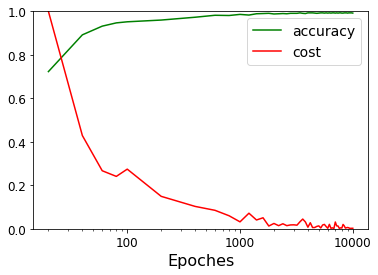

In [14]:
'''作出学习曲线图'''
cost_list = np.array(cost_list)/cost_list[0]

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = ax.plot(epoch_list, acc_list, color='g', label='accuracy')
_ = ax.plot(epoch_list, cost_list, color='r', label='cost')      
_ = ax.set_xscale('log')
_ = ax.set_ylim((0.0, 1.0))
_ = ax.set_xlabel('Epoches', fontsize=16)
_ = ax.set_xticklabels(labels=[1, 10, 100, 1000, 10000], fontsize=12)
_ = ax.set_yticklabels(labels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
_ = ax.legend(fontsize=14)

## 7. 测试准确率
- 准确率为0.9929，也就是说10000张里面就剩71张认不出来了

In [15]:
'''使用测试集测试准确率'''
'''直接把10000数据送进去会内存溢出，所以分成10次算平均值'''
j = 0
b_size = 1000
acc_list = []
while j < test.shape[0]:
    acc = accuracy.eval(feed_dict={x: test[j:j+b_size, 1:], 
                                   y: vectorize(test[j:j+b_size, 0]), 
                                   keep_prob:1.0})
    print(acc, '\t', end='')
    j = j+b_size
    acc_list.append(acc)
print('')
test_accuracy = np.array(acc_list).mean()
print('test accuracy : {0}'.format(test_accuracy))

0.994 	0.986 	0.984 	0.989 	0.996 	0.999 	0.994 	0.998 	0.997 	0.992 	
test accuracy : 0.992900013923645


## 8. 查看识别错误的数字

### 8.1 获取预测值

In [23]:
'''和测试准确率时一样，也是要分成十次计算'''
j = 0
b_size = 1000
pred_flat = np.empty((10, 1000))

while j < test.shape[0]:
    prediction_j = y_.eval(feed_dict={x: test[j:j+b_size, 1:], 
                                y: vectorize(test[j:j+b_size, 0]), 
                                keep_prob:1.0})
    
    pred_flat[j//1000] = [np.argmax(pred) for pred in prediction_j]
    j = j+b_size

In [24]:
'''将对应的预测值和真实值展开成一维数组'''
'''顺便检查一下正确率是否与前面相符'''
pred_y = pred_flat.reshape(10000)
real_y = test[:, 0].reshape(10000)
pred_acc = np.equal(pred_y, real_y).mean()
print('predicton accuracy : ', pred_acc)

predicton accuracy :  0.9929


#### 的确还剩71个数字没有识别出来

### 8.2 定义作图函数

In [25]:
def show_pic(ax, image, y_=None, label=None, wh=28, cmap='Greys'):
    '''
    作图函数：
    ax为Matplotlib.Axes对象；
    image为单个的mnist手写数字特征向量，image.shape is (784,)；
    y_为预测值；
    label为image对应的真实数字标签。
    wh为图片的宽和高，默认是28
    cmap是颜色映射，默认是'Greys'
    '''
    img = image.reshape(wh, wh)
    ax.imshow(img, cmap=cmap)
    ax.axis('off')
    if y_ != None:
        ax.text(28, 22, str(int(y_)), fontsize=16)
    if label != None:
        ax.text(28, 8, str(int(label)), color='r', fontsize=16)

### 8.3 作图

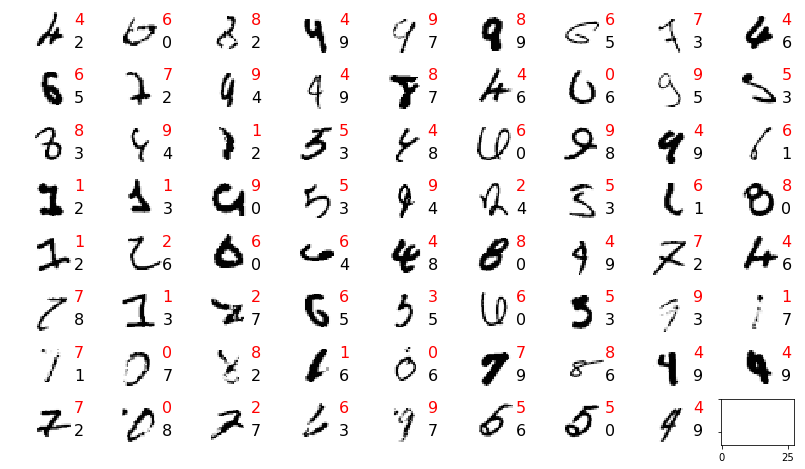

In [41]:
fig, ax = plt.subplots(8, 9, sharex=True, sharey=True)
fig.set_size_inches(14, 8)
ax = ax.flatten()

ax_id = 0
i = 0
while ax_id < 72 :
    image_i = test[i, 1:]
    yi = real_y[i]
    pred_i = pred_y[i]
    if pred_i != yi:
        '''若预测值与真实值不符，则画图'''
        show_pic(ax[ax_id], image_i, pred_i, yi)
        ax_id = ax_id + 1
    
    i = i + 1
    if i>=10000: break

#### 这剩下没认出来的数字有些是挺难认的，而且有几个感觉预测的比真实的要好，比如第1行第4、6个数字，但还是有相当一部分是我们人可以一眼认出来的，所以还有改进的空间。

## 思考：神经网络到底做了什么

### 这里仅做一些启发式的描述，以一个测试样本为例，就比如说测试集第一个数据

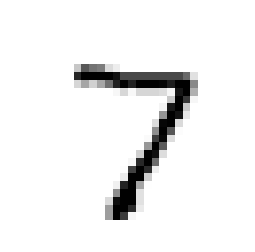

In [28]:
instance = test[0, 1:]

fig, ax = plt.subplots(1, 1)

show_pic(ax, instance)

- 样例数据一眼能认出是7，再看看模型的识别出来的值

In [29]:
pred_i = y_.eval(feed_dict={x: instance.reshape(1, 784), 
                            y: vectorize(test[j:j+b_size, 0]), 
                            keep_prob:1.0})

pred_num = np.argmax(pred_i)
print(pred_num)

7


- 我们的CNN模型的预测值也是7，再看一下它的真实值

In [44]:
print(pred_num == test[0, 0])

True


- 预测值和真实值相等，Go on

### 第一层卷积的32个特征映射

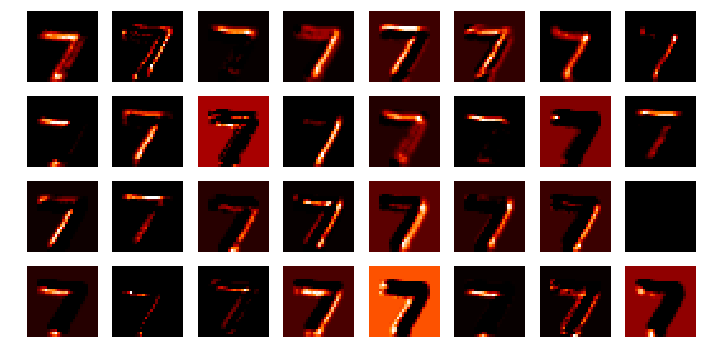

In [36]:
conv_1_feature = h_conv1.eval(feed_dict={x: instance.reshape(1, 784), 
                                         y: vectorize(test[j:j+b_size, 0]), 
                                         keep_prob:1.0})

'''conv_1_feature.shape is (1, 28, 28, 32)'''
fig, ax = plt.subplots(4, 8)
fig.set_size_inches(12, 6)
ax = ax.flatten()

for i in range(32):
    conv_1_img = conv_1_feature[:, :, :, i].reshape(784)
    show_pic(ax[i], conv_1_img, cmap='gist_heat')

- 这32个图片的明暗不同，说明每个特征检测的方式不一样

- 接着看第一层池化后是什么样子

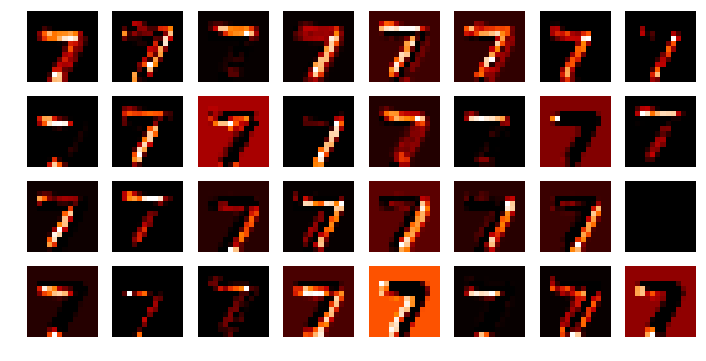

In [35]:
pool_1_feature = pool_1.eval(feed_dict={x: instance.reshape(1, 784), 
                                        y: vectorize(test[j:j+b_size, 0]), 
                                        keep_prob:1.0})

'''pool_1_feature.shape is (1, 14, 14, 32)'''
fig, ax = plt.subplots(4, 8)
fig.set_size_inches(12, 6)
ax = ax.flatten()

for i in range(32):
    pool_1_img = pool_1_feature[:, :, :, i].reshape(14*14)
    show_pic(ax[i], pool_1_img, wh=14, cmap='gist_heat')

- 和我们的池化作用相符，是第一卷积层的缩小版

### 第二卷积层是64个特征

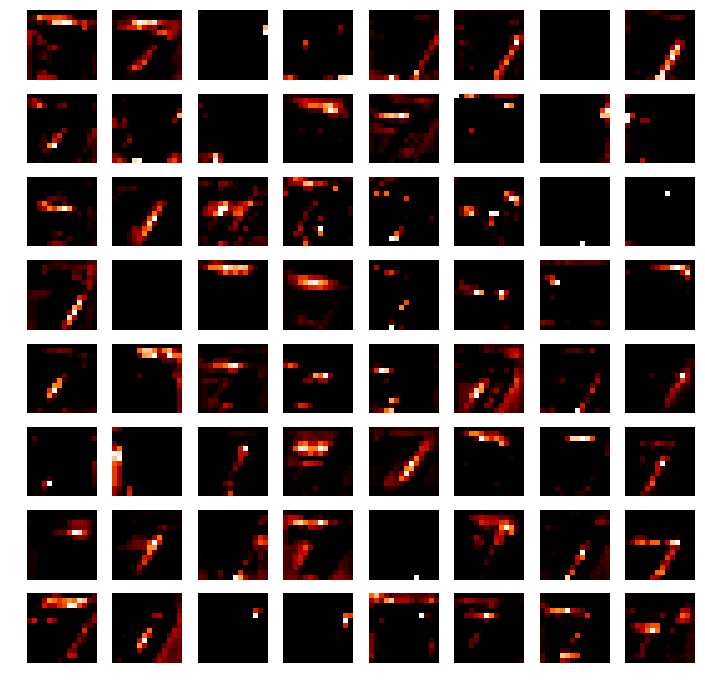

In [37]:
conv_2_feature = h_conv2.eval(feed_dict={x: instance.reshape(1, 784), 
                                         y: vectorize(test[j:j+b_size, 0]), 
                                         keep_prob:1.0})

'''conv_2_feature.shape is (1, 14, 14, 64)'''
fig, ax = plt.subplots(8, 8)
fig.set_size_inches(12, 12)
ax = ax.flatten()

for i in range(64):
    conv_2_img = conv_2_feature[:, :, :, i].reshape(14*14)
    show_pic(ax[i], conv_2_img, wh=14, cmap='gist_heat')

- 这个就有点看不懂了,但还是能隐约看出来映射的是图片不同部位的特征

- 再下来就是第二层池化

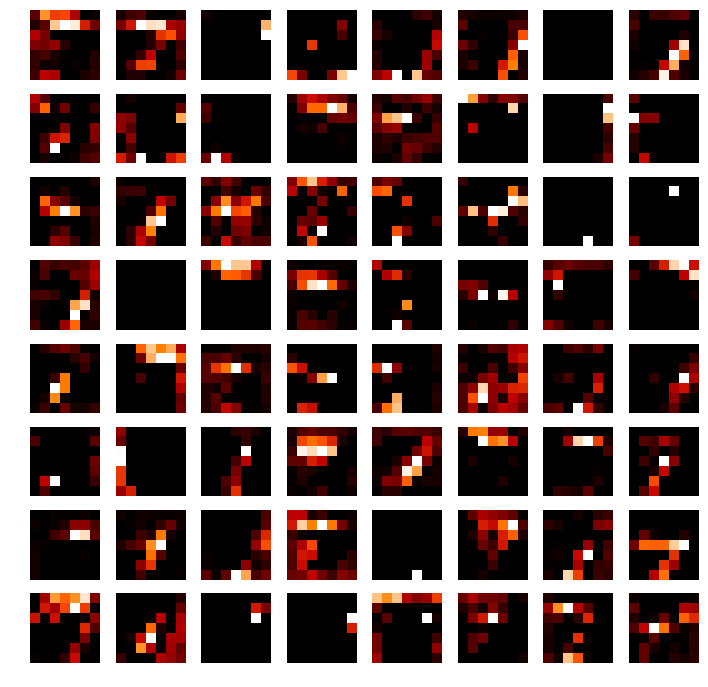

In [38]:
pool_2_feature = pool_2.eval(feed_dict={x: instance.reshape(1, 784), 
                                        y: vectorize(test[j:j+b_size, 0]), 
                                        keep_prob:1.0})

'''pool_2_feature.shape is (1, 7, 7, 64)'''
fig, ax = plt.subplots(8, 8)
fig.set_size_inches(12, 12)
ax = ax.flatten()
for i in range(64):
    pool_2_img = pool_2_feature[:, :, :, i].reshape(7*7)
    show_pic(ax[i], pool_2_img, wh=7, cmap='gist_heat')

- 这个只能隐约再隐约地看出一点点特征了，具体的估计只有我们的CNN模型能看懂了 ~~~

- 好啦，演示就到这里了 ~~

## 最后，关闭会话，结束

In [49]:
sess.close()